# Estimating COVID-19's $R_t$ in Real-Time with PYMC3

Kevin Systrom - April 22

Model originally built by [Thomas Vladeck](https://github.com/tvladeck) in Stan, parts inspired by the work over at https://epiforecasts.io/, lots of help from [Thomas Wiecki](https://twitter.com/twiecki). Thank you to everyone who helped.

This notebook is a WIP - I'll add more context and commentary over the coming week.

In [1]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

## Load State Information
#### Load

In [2]:
import os
import io

In [3]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
mitre_cert = './mitre_cert.crt'
x = requests.get(url=url, verify=mitre_cert).content 
states = pd.read_csv(io.StringIO(x.decode('utf8')), 
                    parse_dates=['date'],index_col=['state', 'date']).sort_index()
# states = pd.read_csv(url,
#                      parse_dates=['date'],
#                      index_col=['state', 'date']).sort_index()

# Note: GU/AS/VI do not have enough data for this model to run
# Note: PR had -384 change recently in total count so unable to model
states = states.drop(['MP', 'GU', 'AS', 'PR', 'VI'])

In [4]:
states.head()

positive  negative  pending  hospitalizedCurrently  \
state date                                                             
AK    2020-03-06       0.0       8.0      1.0                    NaN   
      2020-03-07       0.0      12.0      2.0                    NaN   
      2020-03-08       0.0      14.0      6.0                    NaN   
      2020-03-09       0.0      23.0      9.0                    NaN   
      2020-03-10       0.0      23.0      9.0                    NaN   

                  hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
state date                                                                  
AK    2020-03-06                     NaN             NaN              NaN   
      2020-03-07                     NaN             NaN              NaN   
      2020-03-08                     NaN             NaN              NaN   
      2020-03-09                     NaN             NaN              NaN   
      2020-03-10                     NaN             NaN              NaN   

                  onVentilatorCurrently  onVentilatorCumulative  recovered  \
state date                                                                   
AK    2020-03-06                    NaN                     NaN        NaN   
      2020-03-07                    NaN                     NaN        NaN   
      2020-03-08                    NaN                     NaN        NaN   
      2020-03-09                    NaN                     NaN        NaN   
      2020-03-10                    NaN                     NaN        NaN   

                  ... hospitalized total totalTestResults posNeg  fips  \
state date        ...                                                    
AK    2020-03-06  ...          NaN     9                8      8     2   
      2020-03-07  ...          NaN    14               12     12     2   
      2020-03-08  ...          NaN    20               14     14     2   
      2020-03-09  ...          NaN    32               23     23     2   
      2020-03-10  ...          NaN    32               23     23     2   

                  deathIncrease  hospitalizedIncrease  negativeIncrease  \
state date                                                                
AK    2020-03-06            NaN                   NaN               NaN   
      2020-03-07            0.0                   0.0               4.0   
      2020-03-08            0.0                   0.0               2.0   
      2020-03-09            0.0                   0.0               9.0   
      2020-03-10            0.0                   0.0               0.0   

                  positiveIncrease  totalTestResultsIncrease  
state date                                                    
AK    2020-03-06               NaN                       NaN  
      2020-03-07               0.0                       4.0  
      2020-03-08               0.0                       2.0  
      2020-03-09               0.0                       9.0  
      2020-03-10               0.0                       0.0  

[5 rows x 25 columns]

#### Clean data with known modifications

In [5]:
# Errors in Covidtracking.com
states.loc[('WA','2020-04-21'), 'positive'] = 12512
states.loc[('WA','2020-04-22'), 'positive'] = 12753 
states.loc[('WA','2020-04-23'), 'positive'] = 12753 + 190

states.loc[('VA', '2020-04-22'), 'positive'] = 10266
states.loc[('VA', '2020-04-23'), 'positive'] = 10988

states.loc[('PA', '2020-04-22'), 'positive'] = 35684
states.loc[('PA', '2020-04-23'), 'positive'] = 37053

states.loc[('MA', '2020-04-20'), 'positive'] = 39643

states.loc[('CT', '2020-04-18'), 'positive'] = 17550
states.loc[('CT', '2020-04-19'), 'positive'] = 17962

states.loc[('HI', '2020-04-22'), 'positive'] = 586

states.loc[('RI', '2020-03-07'), 'positive'] = 3

#### Integrity Check

In [6]:
# Make sure that all the states have current data
today = datetime.combine(date.today(), datetime.min.time())
last_updated = states.reset_index('date').groupby('state')['date'].max()
is_current = last_updated < today

try:
    assert is_current.sum() == 0
except AssertionError:
    print("Not all states have updated")
    display(last_updated[is_current])

# Ensure all case diffs are greater than zero
for state, grp in states.groupby('state'):
    new_cases = grp.positive.diff().dropna()
    is_positive = new_cases.ge(0)
    
    try:
        assert is_positive.all()
    except AssertionError:
        print(f"Warning: {state} has date with negative case counts")
        display(new_cases[~is_positive])
        
# Let's make sure that states have added cases
idx = pd.IndexSlice
assert not states.loc[idx[:, '2020-04-22':'2020-04-23'], 'positive'].groupby('state').diff().dropna().eq(0).any()

Not all states have updated


state
AK   2020-05-19
AL   2020-05-19
AR   2020-05-19
AZ   2020-05-19
CA   2020-05-19
CO   2020-05-19
CT   2020-05-19
DC   2020-05-19
DE   2020-05-19
FL   2020-05-19
GA   2020-05-19
HI   2020-05-19
IA   2020-05-19
ID   2020-05-19
IL   2020-05-19
IN   2020-05-19
KS   2020-05-19
KY   2020-05-19
LA   2020-05-19
MA   2020-05-19
MD   2020-05-19
ME   2020-05-19
MI   2020-05-19
MN   2020-05-19
MO   2020-05-19
MS   2020-05-19
MT   2020-05-19
NC   2020-05-19
ND   2020-05-19
NE   2020-05-19
NH   2020-05-19
NJ   2020-05-19
NM   2020-05-19
NV   2020-05-19
NY   2020-05-19
OH   2020-05-19
OK   2020-05-19
OR   2020-05-19
PA   2020-05-19
RI   2020-05-19
SC   2020-05-19
SD   2020-05-19
TN   2020-05-19
TX   2020-05-19
UT   2020-05-19
VA   2020-05-19
VT   2020-05-19
WA   2020-05-19
WI   2020-05-19
WV   2020-05-19
WY   2020-05-19
Name: date, dtype: datetime64[ns]

state  date      
CO     2020-05-12   -20.0
Name: positive, dtype: float64

state  date      
HI     2020-05-15   -1.0
Name: positive, dtype: float64

state  date      
MA     2020-04-20   -177.0
Name: positive, dtype: float64

state  date      
MT     2020-05-05   -1.0
Name: positive, dtype: float64

state  date      
OH     2020-04-27   -264.0
Name: positive, dtype: float64

state  date      
VT     2020-05-11   -1.0
Name: positive, dtype: float64

state  date      
WA     2020-04-21   -268.0
       2020-05-18   -157.0
Name: positive, dtype: float64

## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [7]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True, verify=mitre_cert) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv"
LINELIST_PATH = 'data/linelist.csv'

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
#     try:
    download_file(URL, LINELIST_PATH)
    clear_output(wait=True)
    print('Done downloading.')
#     except:
#         print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Already downloaded CSV


In [ ]:
#====NOTE - THIS CODE DOES NOT DOWNLOAD THE FILE CORREECTLY.
# Try downloading by pinging the url, then extract the tar file to linelist.csv
import urllib.request
import tarfile
URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.tar.gz"
LINELIST_PATH = 'data/linelist.tar.gz'

response = requests.get(url, stream=True, verify=mitre_cert)
if response.status_code == 200:
    print('successfully retrieved file. Downloading to local.')
    with open(LINELIST_PATH, 'wb') as f:
        f.write(response.raw.read())


#### Parse & Clean Patient Info

In [8]:
# Load the patient CSV
patients = pd.read_csv(
    'data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

patients = patients[patients.Confirmed >= patients.Onset]

In [9]:
patients.head(5)

,Onset,Confirmed
53,2020-02-08,2020-02-14
55,2020-02-01,2020-02-13
335,2020-01-30,2020-02-14
365,2020-02-14,2020-02-16
446,2020-02-11,2020-02-15


#### Show Relationship between Onset of Symptoms and Confirmation

In [10]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(9,9))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

ValueError: scatter requires x column to be numeric

#### Calculate the Probability Distribution of Delay

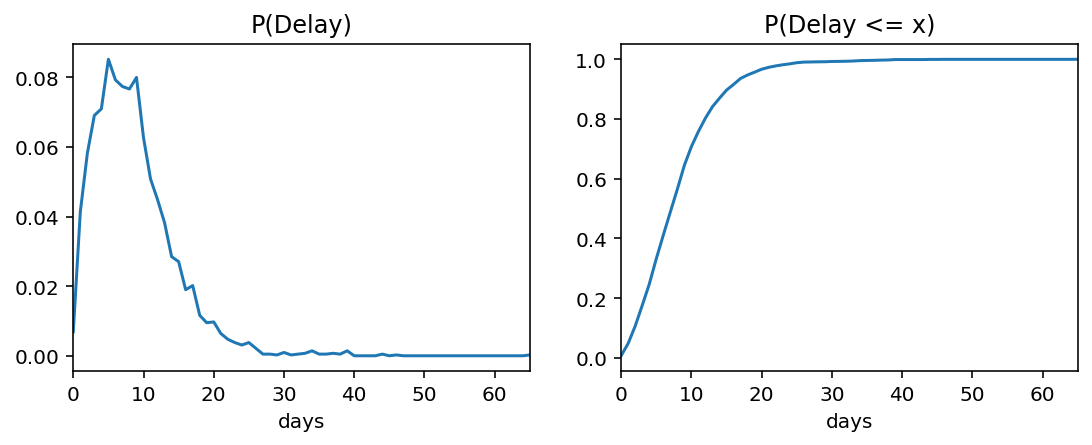

In [11]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

## A Single State

#### Select State Data

In [12]:
state = 'CA'
confirmed = states.xs(state).positive.diff().dropna()
confirmed = confirmed[:-4]
confirmed.tail()

date
2020-05-06    2603.0
2020-05-07    1799.0
2020-05-08    1898.0
2020-05-09    2049.0
2020-05-10    2119.0
Name: positive, dtype: float64

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [13]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset


onset = confirmed_to_onset(confirmed, p_delay)

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [14]:
cumulative_p_delay = p_delay.cumsum()
    
# Calculate the additional ones needed so shapes match
ones_needed = len(onset) - len(cumulative_p_delay)
padding_shape = (0, ones_needed)

# Add ones and flip back
cumulative_p_delay = np.pad(
    cumulative_p_delay,
    padding_shape,
    'constant',
    constant_values=1)
cumulative_p_delay = np.flip(cumulative_p_delay)

# Adjusts observed onset values to expected terminal onset values
adjusted = onset / cumulative_p_delay
cumulative_p_delay = np.flip(cumulative_p_delay)
print('cum_delay: ')
print(cumulative_p_delay[-5:])

print('original onset: ')
print(onset[-5:])
adjusted = onset / cumulative_p_delay
print('adjusted: ')
print(adjusted[-5:])

cum_delay: 
[1. 1. 1. 1. 1.]
original onset: 
2020-05-06    494.273547
2020-05-07    356.122657
2020-05-08    220.812100
2020-05-09    101.572242
2020-05-10     14.579122
Freq: D, dtype: float64
adjusted: 
2020-05-06    494.273547
2020-05-07    356.122657
2020-05-08    220.812100
2020-05-09    101.572242
2020-05-10     14.579122
Freq: D, dtype: float64


In [15]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        'constant',
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


# # adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
# def adjust_onset_for_right_censorship(onset, p_delay):
#     cumulative_p_delay = p_delay.cumsum()
    
#     # Calculate the additional ones needed so shapes match
#     ones_needed = len(onset) - len(cumulative_p_delay)
#     padding_shape = (0, ones_needed)
    
#     # Add ones and flip back
#     cumulative_p_delay = np.concatenate([cumulative_p_delay, np.repeat(1, ones_needed)])
#     cumulative_p_delay = np.flip(cumulative_p_delay)
    
#     # Adjusts observed onset values to expected terminal onset values
#     adjusted = onset / cumulative_p_delay
    
#     return adjusted, cumulative_p_delay


adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

In [16]:
print(state)

CA


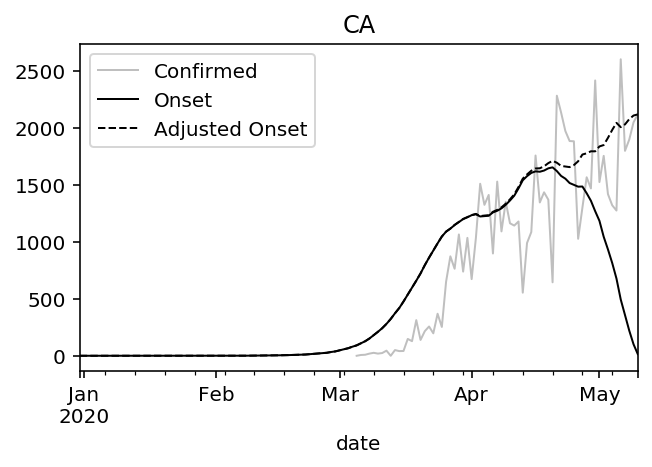

In [17]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=state,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

Let's have the model run on days where we have enough data ~last 50 or so

### Sample the Posterior with PyMC3

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [18]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=50):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self

### Run Pymc3 Model

In [19]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(name, state):
    confirmed = state.positive.diff().dropna()
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

#### States

In [21]:
models = {}

for state, grp in states.groupby('state'):
    
    print(state)
    
    if state in models:
        print(f'Skipping {state}, already in cache')
        continue
    
    models[state] = create_and_run_model(state, grp.droplevel(0))

INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock


AK


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 372.20it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


AL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 211.55it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


AR


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:17<00:00, 224.80it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


AZ


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:34<00:00, 115.16it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


CA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:23<00:00, 171.28it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


CO


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:19<00:00, 209.37it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


CT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:24<00:00, 164.00it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


DC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:17<00:00, 227.90it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


DE


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 219.43it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


FL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 3 divergences: 100%|██████████| 4000/4000 [00:19<00:00, 207.65it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [08:51<00:00,  7.53it/s]  
Only one chain was sampled, this makes it impossible to run some convergence checks


HI


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 394.07it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


IA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:21<00:00, 188.68it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


ID


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 337.62it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


IL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:23<00:00, 168.05it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


IN


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 214.45it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


KS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 214.15it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


KY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:17<00:00, 235.05it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [03:56<00:00, 16.94it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


MA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:35<00:00, 112.45it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


MD


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:21<00:00, 188.41it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


ME


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 319.10it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


MI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:22<00:00, 180.07it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


MN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:22<00:00, 176.02it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


MO


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 237.60it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:17<00:00, 223.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


MT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:08<00:00, 454.35it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [03:31<00:00, 18.95it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


ND


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 256.06it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NE


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:22<00:00, 179.74it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NH


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 255.02it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NJ


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:29<00:00, 133.67it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 220.24it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 245.68it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


NY


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:38<00:00, 103.11it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


OH


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:29<00:00, 137.11it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


OK


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 253.17it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


OR


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 264.73it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:27<00:00, 143.86it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


RI


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:19<00:00, 206.86it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


SC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 235.93it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


SD


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 219.68it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


TN


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 212.26it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 5 divergences: 100%|██████████| 4000/4000 [00:22<00:00, 174.74it/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


UT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 244.57it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


VA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:20<00:00, 197.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


VT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 349.58it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


WA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:19<00:00, 203.66it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


WI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 222.06it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


WV


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 237.51it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


WY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 318.80it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


#### Counties

In [28]:
# read in county counts from usafacts and assume total reported positives = case counts
#UPDATE DATA FILE WITH MOST RECENT FILE
counties = (pd.read_csv('data/county_inf_stats.csv', parse_dates=['date'])
           .assign(positive= lambda x: x.case_count))

# only run on counties with 40 days or more of data
county_cts = counties.groupby('mState.Providence').count()
usable_county_names = set(county_cts.loc[county_cts['positive'] > 40,:].index.values)
usable_counties = counties.loc[counties['mState.Providence'].isin(usable_county_names),:]

# create hierarchical index with county name and deates, and sort 
usable_counties = usable_counties.set_index(['mState.Providence', 'date']).sort_index()
usable_counties.head()

Country.Region  case_count  death_count  \
mState.Providence    date                                                 
Abbeville County, SC 2020-03-17  United States         0.0          0.0   
                     2020-03-18  United States         0.0          0.0   
                     2020-03-19  United States         1.0          0.0   
                     2020-03-20  United States         1.0          0.0   
                     2020-03-21  United States         1.0          0.0   

                                 recovered_count firstDeathDate firstCaseDate  \
mState.Providence    date                                                       
Abbeville County, SC 2020-03-17              NaN            NaN    2020-03-19   
                     2020-03-18              NaN            NaN    2020-03-19   
                     2020-03-19              NaN            NaN    2020-03-19   
                     2020-03-20              NaN            NaN    2020-03-19   
                     2020-03-21              NaN            NaN    2020-03-19   

                                 positive  
mState.Providence    date                  
Abbeville County, SC 2020-03-17       0.0  
                     2020-03-18       0.0  
                     2020-03-19       1.0  
                     2020-03-20       1.0  
                     2020-03-21       1.0

In [37]:
county_models = county_models_backup

for county, grp in usable_counties.groupby('mState.Providence'):
    
    print(county)
    
    if county in county_models or "Statewide Unallocated" in county: #or county == "Seneca County, NY"
        print(f'Skipping {state}, already in cache')
        continue
    
    try:
        county_models[county] = create_and_run_model(county, grp.droplevel(0))
    except:
        pass


Abbeville County, SC
Skipping WY, already in cache
Acadia Parish, LA
Skipping WY, already in cache
Accomack County, VA
Skipping WY, already in cache
Ada County, ID
Skipping WY, already in cache
Adair County, IA
Skipping WY, already in cache
Adair County, KY
Skipping WY, already in cache
Adair County, MO
Skipping WY, already in cache
Adair County, OK
Skipping WY, already in cache
Adams County, CO
Skipping WY, already in cache
Adams County, ID
Skipping WY, already in cache
Adams County, IL
Skipping WY, already in cache
Adams County, IN
Skipping WY, already in cache
Adams County, MS
Skipping WY, already in cache
Adams County, NE
Skipping WY, already in cache
Adams County, OH
Skipping WY, already in cache
Adams County, PA
Skipping WY, already in cache
Adams County, WA
Skipping WY, already in cache
Adams County, WI
Skipping WY, already in cache
Addison County, VT
Skipping WY, already in cache
Aiken County, SC
Skipping WY, already in cache
Alachua County, FL
Skipping WY, already in cache
Ala

Effingham County, GA
Skipping WY, already in cache
Effingham County, IL
Skipping WY, already in cache
El Dorado County, CA
Skipping WY, already in cache
El Paso County, CO
Skipping WY, already in cache
El Paso County, TX
Skipping WY, already in cache
Elbert County, CO
Skipping WY, already in cache
Elbert County, GA
Skipping WY, already in cache
Elkhart County, IN
Skipping WY, already in cache
Elko County, NV
Skipping WY, already in cache
Ellis County, TX
Skipping WY, already in cache
Elmore County, AL
Skipping WY, already in cache
Elmore County, ID
Skipping WY, already in cache
Emanuel County, GA
Skipping WY, already in cache
Emery County, UT
Skipping WY, already in cache
Emmet County, MI
Skipping WY, already in cache
Emmons County, ND
Skipping WY, already in cache
Emporia City, VA
Skipping WY, already in cache
Erath County, TX
Skipping WY, already in cache
Erie County, NY
Skipping WY, already in cache
Erie County, OH
Skipping WY, already in cache
Erie County, PA
Skipping WY, already i

Skipping WY, already in cache
LaPorte County, IN
Skipping WY, already in cache
LaSalle County, IL
Skipping WY, already in cache
Labette County, KS
Skipping WY, already in cache
Lac Qui Parle County, MN
Skipping WY, already in cache
Lackawanna County, PA
Skipping WY, already in cache
Lafayette County, AR
Skipping WY, already in cache
Lafayette County, MO
Skipping WY, already in cache
Lafayette County, MS
Skipping WY, already in cache
Lafayette Parish, LA
Skipping WY, already in cache
Lafourche Parish, LA
Skipping WY, already in cache
Lake County, CO
Skipping WY, already in cache
Lake County, FL
Skipping WY, already in cache
Lake County, IL
Skipping WY, already in cache
Lake County, IN
Skipping WY, already in cache
Lake County, MT
Skipping WY, already in cache
Lake County, OH
Skipping WY, already in cache
Lake County, SD
Skipping WY, already in cache
Lamar County, AL
Skipping WY, already in cache
Lamar County, GA
Skipping WY, already in cache
Lamar County, MS
Skipping WY, already in cach

Skipping WY, already in cache
Ottawa County, MI
Skipping WY, already in cache
Ottawa County, OH
Skipping WY, already in cache
Ottawa County, OK
Skipping WY, already in cache
Otter Tail County, MN
Skipping WY, already in cache
Ouachita County, AR
Skipping WY, already in cache
Ouachita Parish, LA
Skipping WY, already in cache
Ouray County, CO
Skipping WY, already in cache
Outagamie County, WI
Skipping WY, already in cache
Overton County, TN
Skipping WY, already in cache
Owen County, IN
Skipping WY, already in cache
Owyhee County, ID
Skipping WY, already in cache
Oxford County, ME
Skipping WY, already in cache
Ozaukee County, WI
Skipping WY, already in cache
Page County, IA
Skipping WY, already in cache
Page County, VA
Skipping WY, already in cache
Palm Beach County, FL
Skipping WY, already in cache
Palo Pinto County, TX
Skipping WY, already in cache
Pamlico County, NC
Skipping WY, already in cache
Panola County, MS
Skipping WY, already in cache
Panola County, TX
Skipping WY, already in c

INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 403.11it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Ste. Genevieve County, MO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 406.54it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Stearns County, MN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:20<00:00, 198.75it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Steele County, MN


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 398.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Stephens County, GA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 388.71it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Stephens County, OK


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 402.27it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Stephenson County, IL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 387.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Steuben County, IN


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 404.54it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Steuben County, NY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 364.50it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Stevens County, KS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 401.29it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Stevens County, WA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 426.77it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Stewart County, GA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 399.34it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Stewart County, TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 417.01it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Stoddard County, MO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 409.17it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Stokes County, NC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 417.92it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Stone County, AR


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 423.70it/s]
The acceptance probability does not match the target. It is 0.8709488229546696, but should be close to 0.95. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Stone County, MO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 431.70it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Stone County, MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 413.13it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Story County, IA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.55it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Strafford County, NH


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 388.09it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sublette County, WY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 434.14it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Suffolk City, VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 387.71it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Suffolk County, MA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:21<00:00, 184.62it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Suffolk County, NY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:21<00:00, 182.99it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sullivan County, IN


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.86it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sullivan County, NH


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 433.52it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sullivan County, NY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:13<00:00, 307.32it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sullivan County, PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 432.46it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sullivan County, TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 391.42it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Summit County, CO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 387.18it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Summit County, OH


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:13<00:00, 302.64it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Summit County, UT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 398.12it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sumner County, KS


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 421.91it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sumner County, TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 363.04it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sumter County, AL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 400.02it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sumter County, FL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 375.73it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sumter County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 325.11it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sumter County, SC


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 384.68it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sunflower County, MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 410.31it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Surry County, NC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 410.60it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Surry County, VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 404.76it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Susquehanna County, PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 408.18it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sussex County, DE


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:20<00:00, 198.78it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sussex County, NJ


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:14<00:00, 274.49it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sussex County, VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 414.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sutter County, CA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 393.32it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Suwannee County, FL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 394.54it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sweetwater County, WY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 409.06it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Swisher County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 403.55it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Switzerland County, IN


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 423.78it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Talbot County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 413.46it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Talbot County, MD


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 417.55it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Talladega County, AL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 410.00it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tallahatchie County, MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 406.14it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tallapoosa County, AL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 371.52it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tama County, IA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 357.76it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Taney County, MO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 416.39it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tangipahoa Parish, LA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 326.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Taos County, NM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 408.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tarrant County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:19<00:00, 206.23it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tate County, MS


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 405.57it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tattnall County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 421.81it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Taylor County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 398.08it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Taylor County, IA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 429.29it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Taylor County, KY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 433.47it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Taylor County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 382.81it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tazewell County, IL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.41it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tazewell County, VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 431.72it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tehama County, CA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 427.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Telfair County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 410.19it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Teller County, CO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.62it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Terrebonne Parish, LA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 356.17it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Terrell County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 399.75it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Terry County, TX


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 418.27it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Teton County, ID


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 419.21it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Teton County, WY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 419.05it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Texas County, OK


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:14<00:00, 275.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Thomas County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 387.01it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Thurston County, WA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 394.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tift County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 389.88it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tillamook County, OR


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 424.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tillman County, OK


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 408.97it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tioga County, NY


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 405.94it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tioga County, PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 420.73it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tippah County, MS


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 418.10it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tippecanoe County, IN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 373.34it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tipton County, IN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 409.74it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tipton County, TN


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:13<00:00, 301.48it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tishomingo County, MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 412.08it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Titus County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 404.44it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Todd County, SD


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 353.73it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tolland County, CT


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 329.54it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tom Green County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 396.64it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tompkins County, NY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 320.81it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tooele County, UT


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 414.03it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Toole County, MT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 412.25it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Toombs County, GA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 392.25it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Torrance County, NM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 409.04it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Towns County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 403.33it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Transylvania County, NC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 427.14it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Traverse County, MN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 423.70it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Travis County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 250.80it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Trempealeau County, WI


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 429.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Trinity County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 411.52it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Troup County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 381.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Trousdale County, TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:35<00:00, 111.15it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Trumbull County, OH


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 367.33it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tucker County, WV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 411.00it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tulare County, CA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 245.64it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tulsa County, OK


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 336.17it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tunica County, MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 404.98it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tuolumne County, CA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 423.65it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Turner County, GA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Turner County, SD


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 417.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tuscaloosa County, AL


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 374.51it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tuscarawas County, OH


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 360.20it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tuscola County, MI


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 398.11it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Twiggs County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 411.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Twin Falls County, ID


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 383.12it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Tyler County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 415.48it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Uinta County, WY


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 417.24it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Uintah County, UT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 417.91it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Ulster County, NY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 260.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Umatilla County, OR


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 389.42it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Unicoi County, TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 427.29it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, AR


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 418.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, FL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 413.14it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 402.96it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, IN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 425.71it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, KY


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 395.36it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 414.47it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, NC


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 376.73it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, NJ


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:21<00:00, 185.01it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, OH


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 412.41it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, OR


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 428.90it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.12it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, SC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 409.42it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, SD


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 404.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union County, TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 440.81it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Union Parish, LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 380.47it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Upshur County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 405.91it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Upshur County, WV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 426.59it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Upson County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 381.91it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Utah County, UT


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 249.30it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Uvalde County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 425.60it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Val Verde County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 410.69it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Valencia County, NM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 417.11it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Valley County, ID


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 436.82it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Van Buren County, AR


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 384.49it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Van Buren County, IA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 416.31it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Van Buren County, MI


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 399.25it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Van Wert County, OH


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 423.92it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Van Zandt County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 411.42it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Vance County, NC


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 373.80it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Vanderburgh County, IN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 386.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Venango County, PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 426.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Ventura County, CA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 358.92it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Vermilion County, IL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 402.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Vermilion Parish, LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 404.07it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Vermillion County, IN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 416.15it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Vernon Parish, LA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 417.22it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Victoria County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 395.11it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Vigo County, IN


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 399.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Vilas County, WI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 413.20it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Virginia Beach City, VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 350.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Volusia County, FL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 339.74it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wabash County, IN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 394.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wabasha County, MN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 406.31it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wabaunsee County, KS


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 404.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wagoner County, OK


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 392.03it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wahkiakum County, WA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 415.39it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wake County, NC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 321.45it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wakulla County, FL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 402.84it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Waldo County, ME


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 398.14it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Walker County, AL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 408.38it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Walker County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.78it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Walker County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 338.21it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Walla Walla County, WA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 379.58it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Waller County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.21it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wallowa County, OR


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 415.99it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Walsh County, ND


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 422.77it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Walthall County, MS


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.70it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Walton County, FL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 400.43it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Walton County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 388.05it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Walworth County, WI


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 363.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wapello County, IA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:14<00:00, 284.90it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Ward County, ND


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 408.32it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Ware County, GA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 405.04it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Warren County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 414.69it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Warren County, IA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 406.93it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Warren County, IN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 408.86it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Warren County, KY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 1 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 259.41it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Warren County, MO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 389.98it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Warren County, MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 390.08it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Warren County, NC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 408.16it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Warren County, NJ


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:14<00:00, 282.94it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Warren County, NY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 379.45it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Warren County, OH


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 383.61it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Warren County, PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 436.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Warren County, TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 392.28it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Warren County, VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 400.41it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Warrick County, IN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 434.11it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wasatch County, UT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 385.16it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wasco County, OR


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 417.18it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Waseca County, MN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 422.58it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washakie County, WY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 427.35it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, AL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 405.23it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, AR


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 402.75it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, CO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 412.49it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, FL


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 403.13it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 415.67it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, IA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 410.36it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, ID


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 412.30it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, IL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.62it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, IN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 399.78it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, KY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 419.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, MD


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 353.46it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, ME


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 412.03it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, MN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 368.55it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 405.38it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, NC


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 413.07it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, NE


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 409.65it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, NY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 357.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, OH


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 400.00it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, OK


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 349.91it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, OR


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 361.29it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 389.07it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, RI


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 328.34it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 394.74it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 386.89it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, UT


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 404.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 403.97it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, VT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 411.24it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington County, WI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 408.17it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington Parish, LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 381.98it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washington, DC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:19<00:00, 209.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washoe County, NV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:14<00:00, 269.65it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Washtenaw County, MI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 309.06it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Watauga County, NC


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 424.29it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Watonwan County, MN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 344.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Waukesha County, WI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 358.61it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Waupaca County, WI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 368.89it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wayne County, GA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 404.46it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wayne County, IN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 420.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wayne County, KY


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 419.97it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wayne County, MI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:22<00:00, 179.77it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wayne County, MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 413.93it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wayne County, NC


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:18<00:00, 220.77it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wayne County, NY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 412.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wayne County, OH


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 390.43it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wayne County, PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 403.50it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wayne County, TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 423.22it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Waynesboro City, VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 404.29it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Weakley County, TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 410.72it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Webb County, TX


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 385.65it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Weber County, UT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 400.49it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Webster County, GA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 418.74it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Webster County, IA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 409.03it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Webster County, KY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 421.85it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Webster County, MO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 401.92it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Webster County, MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 397.46it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Webster Parish, LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 403.06it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Weld County, CO


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 238.59it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wells County, IN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 413.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


West Baton Rouge Parish, LA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 399.85it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


West Feliciana Parish, LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 397.37it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Westchester County, NY


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:19<00:00, 205.75it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Westmoreland County, PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 359.47it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Westmoreland County, VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 413.00it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wetzel County, WV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 421.70it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wexford County, MI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 421.51it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wharton County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 410.14it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Whatcom County, WA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 385.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wheeler County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 421.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


White County, AR


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 419.85it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


White County, GA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.78it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


White County, IN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 374.99it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


White County, TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 417.91it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


White Pine County, NV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 421.18it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Whiteside County, IL


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.27it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Whitfield County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 376.03it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Whitley County, IN


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 391.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Whitman County, WA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 427.00it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wichita County, TX


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 414.96it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wicomico County, MD


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 254.19it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wilcox County, AL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 388.47it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wilcox County, GA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 409.41it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wilkes County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 410.43it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wilkes County, NC


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 327.21it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wilkin County, MN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 421.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wilkinson County, GA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.76it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wilkinson County, MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 402.68it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Will County, IL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:19<00:00, 202.15it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Willacy County, TX


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 407.72it/s]
The acceptance probability does not match the target. It is 0.8958758138249852, but should be close to 0.95. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Williams County, ND


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 400.52it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Williams County, OH


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 396.97it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Williamsburg City, VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 401.45it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Williamsburg County, SC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 381.57it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Williamson County, IL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 398.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Williamson County, TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 365.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Williamson County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 347.51it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wilson County, NC


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 370.93it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wilson County, TN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 360.55it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wilson County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 413.36it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Winchester City, VA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 400.67it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Windham County, CT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 364.42it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Windham County, VT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 388.66it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Windsor County, VT


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 411.09it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Winn Parish, LA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 398.86it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Winnebago County, IL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:17<00:00, 232.26it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Winnebago County, WI


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 401.11it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Winneshiek County, IA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 397.16it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Winona County, MN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 404.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Winston County, AL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 398.77it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Winston County, MS


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 400.33it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wirt County, WV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 413.36it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wise County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 409.85it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wise County, VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 396.85it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wood County, OH


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 376.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wood County, TX


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 394.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wood County, WI


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 411.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wood County, WV


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 405.10it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Woodbury County, IA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:20<00:00, 191.70it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Woodford County, IL


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 421.08it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Woodford County, KY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 401.59it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Woodruff County, AR


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:07<00:00, 517.12it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Woodson County, KS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 417.77it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Woodward County, OK


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 425.51it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Worcester County, MA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:20<00:00, 194.41it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Worcester County, MD


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 390.70it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Worth County, GA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 398.37it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wright County, IA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 416.78it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wright County, MN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 391.10it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wright County, MO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 415.16it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wyandot County, OH


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 399.42it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wyandotte County, KS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 243.82it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wyoming County, NY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 394.41it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wyoming County, PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 394.36it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Wythe County, VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 396.16it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yadkin County, NC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 382.23it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yakima County, WA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 235.86it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yalobusha County, MS


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 397.50it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yamhill County, OR


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 403.90it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yankton County, SD


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 372.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yates County, NY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 404.05it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yavapai County, AZ


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 383.15it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yazoo County, MS


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 369.22it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yell County, AR


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 409.26it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yellow Medicine County, MN


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 416.74it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yellowstone County, MT


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 400.74it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yolo County, CA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 406.96it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


York County, ME


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 390.37it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


York County, NE


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 392.50it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


York County, PA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 332.30it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


York County, SC


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 392.22it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


York County, VA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 387.69it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Young County, TX


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 415.35it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yuba County, CA


INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:10<00:00, 386.53it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yukon-Koyukuk Census Area, AK


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 426.29it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yuma County, AZ


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 352.64it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Yuma County, CO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 410.07it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [38]:
len(county_models)

2408

In [39]:
county_models_backup = county_models.copy()

### Handle Divergences

#### States

In [22]:
# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
divergences = pd.Series([n_diverging(m) for m in models.values()], index=models.keys())
has_divergences = divergences.gt(0)

print('Diverging states:')
display(divergences[has_divergences])

# Rerun states with divergences
for state, n_divergences in divergences[has_divergences].items():
    models[state].run()

Diverging states:


CO    1
DE    1
FL    3
TN    1
TX    5
dtype: int64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:19<00:00, 203.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 3 divergences: 100%|██████████| 4000/4000 [00:19<00:00, 201.53it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 diver

#### Counties

In [46]:
# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
cty_divergences = pd.Series([n_diverging(m) for m in county_models.values()], index=county_models.keys())
has_divergences = cty_divergences.gt(0)

print('Diverging counties:')
display(cty_divergences[has_divergences])

# Rerun counties with divergences
for county, n_divergences in cty_divergences[has_divergences].items():
    county_models[county].run()

Diverging counties:


Allen County, IN              1
Chester County, PA            1
Clark County, NV              1
Delaware County, PA           3
Franklin County, OH           1
Palm Beach County, FL         1
Prince George's County, MD    1
Travis County, TX             1
Warren County, KY             1
dtype: int64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 242.67it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:15<00:00, 252.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [00:16<00:00, 246.75it/s]
Only one chain was sam

## Compile Results

#### States

In [23]:
results = None

for state, model in models.items():

    df = df_from_model(model)

    if results is None:
        results = df
    else:
        results = pd.concat([results, df], axis=0)

#### Counties

In [47]:
cty_results = None

for i, (county, model) in enumerate(county_models.items()):
    print('{}: {}'.format(i, county))
    try:
        df = df_from_model(model)

        if cty_results is None:
            cty_results = df
        else:
            cty_results = pd.concat([cty_results, df], axis=0)
    except:
        print('error getting results for {}'.format(county))

0: Abbeville County, SC
1: Acadia Parish, LA
2: Accomack County, VA
3: Ada County, ID
4: Adair County, IA
5: Adair County, KY
6: Adair County, MO
7: Adair County, OK
8: Adams County, CO
9: Adams County, ID
10: Adams County, IL
11: Adams County, IN
12: Adams County, MS
13: Adams County, NE
14: Adams County, OH
15: Adams County, PA
16: Adams County, WA
17: Adams County, WI
18: Addison County, VT
19: Aiken County, SC
20: Alachua County, FL
21: Alamance County, NC
22: Alameda County, CA
23: Alamosa County, CO
24: Albany County, NY
25: Albany County, WY
26: Albemarle County, VA
27: Alcorn County, MS
28: Alexander County, NC
29: Alexandria City, VA
30: Allamakee County, IA
31: Allegan County, MI
32: Allegany County, MD
33: Allegany County, NY
34: Alleghany County, NC
35: Alleghany County, VA
36: Allegheny County, PA
37: Allen County, IN
38: Allen County, KY
39: Allen County, OH
40: Allen Parish, LA
41: Allendale County, SC
42: Alpine County, CA
43: Amador County, CA
44: Amelia County, VA
45:

353: Charles County, MD
354: Charles Mix County, SD
355: Charleston County, SC
356: Charlevoix County, MI
357: Charlotte County, FL
358: Charlotte County, VA
359: Charlottesville City, VA
360: Charlton County, GA
361: Chatham County, GA
362: Chatham County, NC
363: Chattahoochee County, GA
364: Chattooga County, GA
365: Chautauqua County, KS
366: Chautauqua County, NY
367: Chaves County, NM
368: Cheatham County, TN
369: Cheboygan County, MI
370: Chelan County, WA
371: Chemung County, NY
372: Chenango County, NY
373: Cherokee County, AL
374: Cherokee County, GA
375: Cherokee County, KS
376: Cherokee County, NC
377: Cherokee County, OK
378: Cherokee County, SC
379: Cherokee County, TX
380: Cherry County, NE
381: Chesapeake City, VA
382: Cheshire County, NH
383: Chester County, PA
384: Chester County, SC
385: Chester County, TN
386: Chesterfield County, SC
387: Chesterfield County, VA
388: Chickasaw County, MS
389: Chicot County, AR
390: Chilton County, AL
391: Chippewa County, WI
392: Ch

697: Evangeline Parish, LA
698: Fairbanks North Star Borough, AK
699: Fairfax County, VA
700: Fairfield County, CT
701: Fairfield County, OH
702: Fairfield County, SC
703: Fall River County, SD
704: Falls County, TX
705: Fannin County, GA
706: Fannin County, TX
707: Faribault County, MN
708: Faulk County, SD
709: Faulkner County, AR
710: Fauquier County, VA
711: Fayette County, AL
712: Fayette County, GA
713: Fayette County, IA
714: Fayette County, IL
715: Fayette County, IN
716: Fayette County, KY
717: Fayette County, OH
718: Fayette County, PA
719: Fayette County, TN
720: Fayette County, TX
721: Fentress County, TN
722: Ferry County, WA
723: Fillmore County, MN
724: Finney County, KS
725: Flagler County, FL
726: Flathead County, MT
727: Florence County, SC
728: Florence County, WI
729: Floyd County, GA
730: Floyd County, IN
731: Fluvanna County, VA
732: Fond du Lac County, WI
733: Ford County, IL
734: Ford County, KS
735: Forest County, PA
736: Forrest County, MS
737: Forsyth County,

1045: Jackson County, MO
1046: Jackson County, MS
1047: Jackson County, OK
1048: Jackson County, OR
1049: Jackson County, TN
1050: Jackson County, TX
1051: Jackson County, WI
1052: Jackson County, WV
1053: Jackson Parish, LA
1054: James City County, VA
1055: Jasper County, GA
1056: Jasper County, IA
1057: Jasper County, IL
1058: Jasper County, IN
1059: Jasper County, MO
1060: Jasper County, MS
1061: Jasper County, SC
1062: Jasper County, TX
1063: Jay County, IN
1064: Jefferson County, AL
1065: Jefferson County, AR
1066: Jefferson County, CO
1067: Jefferson County, FL
1068: Jefferson County, GA
1069: Jefferson County, IA
1070: Jefferson County, ID
1071: Jefferson County, IN
1072: Jefferson County, KS
1073: Jefferson County, KY
1074: Jefferson County, MO
1075: Jefferson County, MS
1076: Jefferson County, MT
1077: Jefferson County, NY
1078: Jefferson County, OH
1079: Jefferson County, TN
1080: Jefferson County, TX
1081: Jefferson County, WA
1082: Jefferson County, WI
1083: Jefferson Count

1380: Marion County, WV
1381: Marlboro County, SC
1382: Marquette County, MI
1383: Marquette County, WI
1384: Marshall County, AL
1385: Marshall County, IA
1386: Marshall County, IL
1387: Marshall County, IN
1388: Marshall County, KY
1389: Marshall County, MS
1390: Marshall County, SD
1391: Marshall County, TN
1392: Marshall County, WV
1393: Martin County, FL
1394: Martin County, IN
1395: Martin County, KY
1396: Martin County, MN
1397: Martin County, NC
1398: Martin County, TX
1399: Mason County, IL
1400: Mason County, KY
1401: Mason County, TX
1402: Mason County, WA
1403: Mason County, WV
1404: Massac County, IL
1405: Matagorda County, TX
1406: Matanuska-Susitna Borough, AK
1407: Matthews County, VA
1408: Maui County, HI
1409: Maury County, TN
1410: Maverick County, TX
1411: Mayes County, OK
1412: McClain County, OK
1413: McCook County, SD
1414: McCormick County, SC
1415: McCracken County, KY
1416: McCreary County, KY
1417: McCurtain County, OK
1418: McDonald County, MO
1419: McDowell

1707: Pendleton County, KY
1708: Pendleton County, WV
1709: Pennington County, SD
1710: Penobscot County, ME
1711: Peoria County, IL
1712: Perquimans County, NC
1713: Perry County, AR
1714: Perry County, KY
1715: Perry County, MO
1716: Perry County, MS
1717: Perry County, OH
1718: Perry County, PA
1719: Perry County, TN
1720: Person County, NC
1721: Petersburg Census Area, AK
1722: Petersburg City, VA
1723: Pettis County, MO
1724: Philadelphia County, PA
1725: Phillips County, AR
1726: Phillips County, CO
1727: Piatt County, IL
1728: Pickaway County, OH
1729: Pickens County, AL
1730: Pickens County, GA
1731: Pickens County, SC
1732: Pierce County, GA
1733: Pierce County, ND
1734: Pierce County, WA
1735: Pierce County, WI
1736: Pike County, AL
1737: Pike County, AR
1738: Pike County, GA
1739: Pike County, IL
1740: Pike County, KY
1741: Pike County, MO
1742: Pike County, MS
1743: Pike County, OH
1744: Pike County, PA
1745: Pima County, AZ
1746: Pinal County, AZ
1747: Pinellas County, FL


2029: St. Lawrence County, NY
2030: St. Louis City, MO
2031: St. Louis County, MN
2032: St. Louis County, MO
2033: St. Lucie County, FL
2034: St. Martin Parish, LA
2035: St. Mary Parish, LA
2036: St. Mary's County, MD
2037: St. Tammany Parish, LA
2038: Stafford County, KS
2039: Stafford County, VA
2040: Stanislaus County, CA
2041: Stanly County, NC
2042: Stark County, ND
2043: Stark County, OH
2044: Starke County, IN
2045: Starr County, TX
2046: Statewide Unallocated, AK
2047: Staunton City, VA
2048: Ste. Genevieve County, MO
2049: Stearns County, MN
2050: Steele County, MN
2051: Stephens County, GA
2052: Stephens County, OK
2053: Stephenson County, IL
2054: Steuben County, IN
2055: Steuben County, NY
2056: Stevens County, KS
2057: Stevens County, WA
2058: Stewart County, GA
2059: Stewart County, TN
2060: Stoddard County, MO
2061: Stokes County, NC
2062: Stone County, AR
2063: Stone County, MO
2064: Stone County, MS
2065: Story County, IA
2066: Strafford County, NH
2067: Sublette Count

2355: Winn Parish, LA
2356: Winnebago County, IL
2357: Winnebago County, WI
2358: Winneshiek County, IA
2359: Winona County, MN
2360: Winston County, AL
2361: Winston County, MS
2362: Wirt County, WV
2363: Wise County, TX
2364: Wise County, VA
2365: Wood County, OH
2366: Wood County, TX
2367: Wood County, WI
2368: Wood County, WV
2369: Woodbury County, IA
2370: Woodford County, IL
2371: Woodford County, KY
2372: Woodruff County, AR
2373: Woodson County, KS
2374: Woodward County, OK
2375: Worcester County, MA
2376: Worcester County, MD
2377: Worth County, GA
2378: Wright County, IA
2379: Wright County, MN
2380: Wright County, MO
2381: Wyandot County, OH
2382: Wyandotte County, KS
2383: Wyoming County, NY
2384: Wyoming County, PA
2385: Wythe County, VA
2386: Yadkin County, NC
2387: Yakima County, WA
2388: Yalobusha County, MS
2389: Yamhill County, OR
2390: Yankton County, SD
2391: Yates County, NY
2392: Yavapai County, AZ
2393: Yazoo County, MS
2394: Yell County, AR
2395: Yellow Medicine

### Render to CSV
Uncomment if you'd like

In [57]:
# States
results.to_csv('data/rt_states.csv', index=True)

# Counties
cty_results.to_csv('data/rt_counties.csv', index=True)

### Render Charts

In [25]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05), region_col='state', raw_data=[]):
    ax.set_ylim(0.5, 1.6)
    if len(raw_data) == 0:
        region_df = states if region_col=='state' else usable_counties
        region_inds = region_df.index.get_level_values(region_col).isin([name])
    else:
        region_df = raw_data
        region_inds = np.repeat(True, raw_data.shape[0])
        
    num_days = sum(region_inds)
    tot_cases = max(region_df.loc[region_inds, 'positive'])
    
    graph_title = '{} ({} dys, {} cases)'.format(name, num_days, int(tot_cases))
    ax.set_title(graph_title)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_90'].values,
        result['upper_90'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

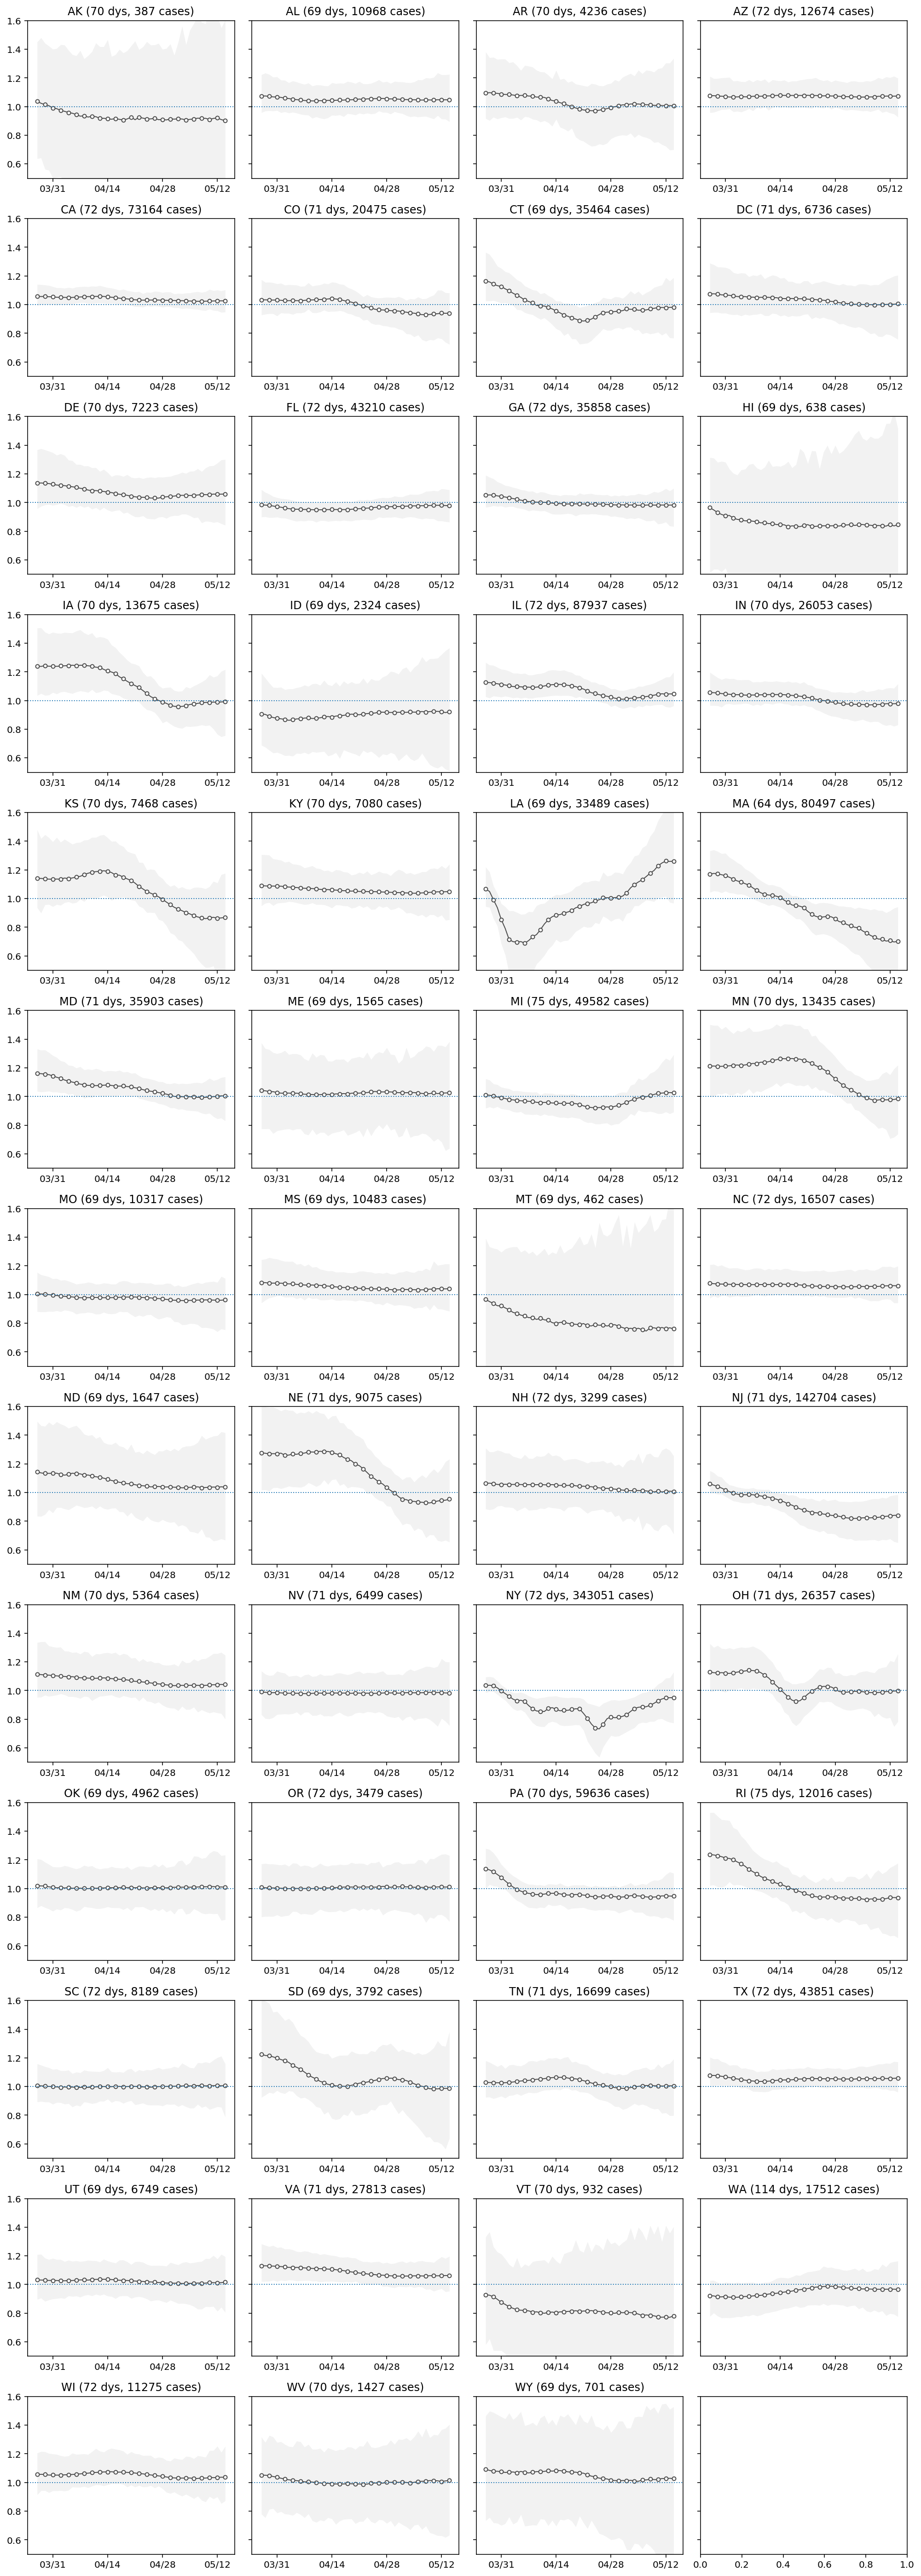

In [26]:
ncols = 4
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

for ax, (state, result) in zip(axes.flat, results.groupby('region')):
    plot_rt(state, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')

In [27]:
ncols = 4
nrows = int(np.ceil(cty_results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

for ax, (county, result) in zip(axes.flat, cty_results.groupby('region')):
    plot_rt(county, result.droplevel(0), ax, region_col='mState.Providence')

fig.tight_layout()
fig.set_facecolor('w')

NameError: name 'cty_results' is not defined

In [ ]:
states.to_csv('data/state_testing.csv')

#### National

In [49]:
nat_cts = states.groupby('date').sum()
nat_cts
region = 'United States'
nat_model = create_and_run_model(region, nat_cts)

INFO (theano.gof.compilelock): Refreshing lock /Users/kafitzgerald/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:02<00:00, 64.03it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


                              mean    median  lower_90  upper_90  lower_50  \
region        date                                                           
United States 2020-03-27  1.109278  1.100697  1.032463  1.179811  1.062582   
              2020-03-28  1.106994  1.099094  1.031208  1.175641  1.058287   
              2020-03-29  1.093600  1.087168  1.020514  1.148901  1.058603   
              2020-03-30  1.070524  1.065688  1.015232  1.117781  1.038284   
              2020-03-31  1.046472  1.042516  1.007251  1.082928  1.020073   
              2020-04-01  1.024904  1.021953  0.997831  1.059038  1.008116   
              2020-04-02  1.000300  1.000772  0.972302  1.026099  0.993387   
              2020-04-03  0.984903  0.987238  0.954263  1.013166  0.980763   
              2020-04-04  0.985384  0.987498  0.955578  1.011364  0.980777   
              2020-04-05  0.992222  0.993503  0.966101  1.021069  0.986714   
              2020-04-06  0.988835  0.990397  0.963767  1.019724

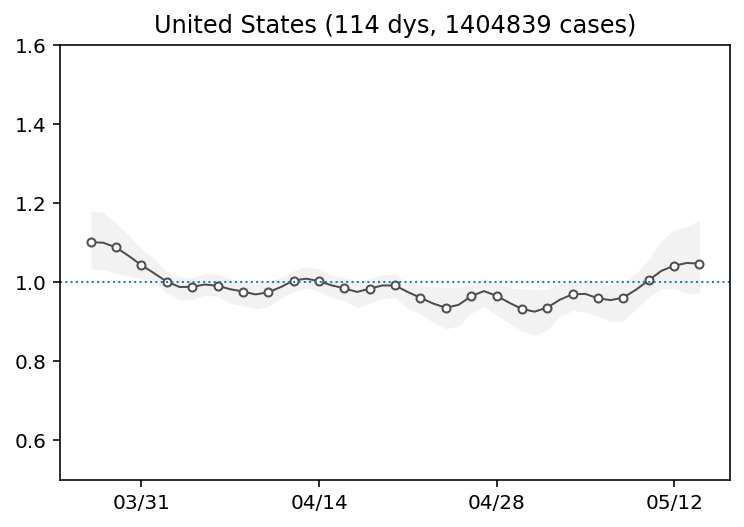

In [55]:
nat_fig, nat_ax = plt.subplots()
nat_res = df_from_model(nat_model)
plot_rt('United States', nat_res.droplevel(0), nat_ax, raw_data = nat_cts)
nat_res.to_csv('data/rt_national.csv', index=True)

In [ ]:
# url = 'https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv'
# abbrev = pd.read_csv(url, index_col=['State'], squeeze=True)

# jhu_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
# jhu = pd.read_csv(jhu_url)

# jhu = jhu.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
# jhu = jhu.set_index('Province_State')
# jhu.index = jhu.index.rename('region')
# jhu = jhu.drop([
#     'American Samoa',
#     'Guam',
#     'Northern Mariana Islands',
#     'Puerto Rico',
#     'Virgin Islands',
#     'Diamond Princess',
#     'Grand Princess'])

# jhu.index = pd.Index(jhu.index.to_series().replace(abbrev).values, name='region')
# jhu.columns = pd.to_datetime(jhu.columns)
# jhu = jhu.groupby('region').sum()
# jhu = jhu.stack().sort_index()

# state = 'VT'
# ax = jhu.xs(state).diff().plot(label='JHU', color='k', legend=True, title=state)
# # jhu.xs('AK').diff().rolling(7).mean().plot(ax=ax)
# states.xs(state).positive.diff().plot(ax=ax, figsize=(6,4), linestyle=':', label='Covidtracking', legend=True)
# ax.set_xlim(pd.Timestamp('2020-03-01'),None)

In [ ]:
# url = 'https://raw.githubusercontent.com/epiforecasts/covid-regional/3ad63ea1acceb797f0628a8037fc206342d267e7/united-states/regional-summary/rt.csv'

# epf = pd.read_csv(url, parse_dates=['date'])
# epf.region = epf.region.replace(abbrev)
# epf = epf.set_index(['region', 'date']).sort_index()
# epf = epf.drop(['Guam', 'Puerto Rico'])

# epf_lookup = {}
# for idx, grp in epf.groupby('region'):

#     epf_lookup[idx]=grp
#     epf_grp = epf_lookup[state]
    
#     plot_rt(state, result.droplevel(0), ax)
#     plot_rt(state, epf_grp.droplevel(0), ax, c=(1,0,0,1))